In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

from pyspark.sql.functions import col, sum, round, countDistinct, max, variance, log10, when

from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import lit
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator



In [108]:
# Initialize Spark Session
spark = SparkSession.builder.appName("HealthCareModel").getOrCreate()

In [109]:
part_d_data_path = "../DataSet/PrescribersByProviderDrug/Medicare_Part_D_Prescribers_by_Provider_and_Drug_2021.csv"
df = spark.read.csv(part_d_data_path, header=True, inferSchema=True)



In [110]:
df.printSchema()


root
 |-- Prscrbr_NPI: integer (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Prscrbr_Type_Src: string (nullable = true)
 |-- Brnd_Name: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Clms: integer (nullable = true)
 |-- Tot_30day_Fills: double (nullable = true)
 |-- Tot_Day_Suply: integer (nullable = true)
 |-- Tot_Drug_Cst: double (nullable = true)
 |-- Tot_Benes: integer (nullable = true)
 |-- GE65_Sprsn_Flag: string (nullable = true)
 |-- GE65_Tot_Clms: integer (nullable = true)
 |-- GE65_Tot_30day_Fills: double (nullable = true)
 |-- GE65_Tot_Drug_Cst: double (nullable = true)
 |-- GE65_Tot_Day_Suply: integer (nullable = true)
 |-- GE65_Bene_Sprsn_Flag: string (nullable = true)
 |-- GE65_T

In [111]:
part_d_data_t = df.select(
    col("Prscrbr_NPI").alias("npi"),
    col("Prscrbr_City").alias("city"),
    col("Prscrbr_State_Abrvtn").alias("state"),
    col("Prscrbr_Last_Org_Name").alias("last_name"),
    col("Prscrbr_First_Name").alias("first_name"),
    col("Prscrbr_Type").alias("specialty"),
    col("Brnd_Name").alias("drug_name"),
    col("Gnrc_Name").alias("generic_name"),
    col("Tot_Drug_Cst").alias("total_drug_cost"),
    col("Tot_Clms").alias("total_claim_count"),
    col("Tot_Day_Suply").alias("total_day_supply")
)

In [112]:
# Step 1: Assign one DataFrame to another
part_d_pd1 = part_d_data_t

# Step 2: Select specific columns
part_d_drug_df = part_d_data_t.select("npi", "drug_name", "total_drug_cost", "total_claim_count", "total_day_supply", "specialty")

# Step 3: Change the data type of 'npi' to StringType
part_d_drug_df = part_d_drug_df.withColumn("npi", col("npi").cast(StringType()))

# Step 4: Select specific columns from another DataFrame
part_d_spec_df1 = part_d_data_t.select("npi", "specialty")

# Step 5: Show the first few rows (equivalent to head(0) in Pandas)
part_d_spec_df1.show()
part_d_drug_df.show()

+----------+-----------------+
|       npi|        specialty|
+----------+-----------------+
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
+----------+-----------------+
only showing top 20 rows

+----------+--------------------+---------------+-----------------+----------------+-----------------+
|       npi|           drug_name|total_drug_cost|total_claim_count|total_day_supply|        specialty|
+----------+------------

In [113]:
part_d_pd2 = part_d_data_t.select('npi',
                                  'city',
                                  'state',
                                  'last_name',
                                  'first_name',
                                  'specialty')

part_d_pd2.show()

+----------+--------+-----+---------+----------+-----------------+
|       npi|    city|state|last_name|first_name|        specialty|
+----------+--------+-----+---------+----------+-----------------+
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medic

In [114]:
part_d_pd_u = part_d_pd2.dropDuplicates()

# Show the result
part_d_pd_u.show()

+----------+-------------+-----+---------+----------+-------------------+
|       npi|         city|state|last_name|first_name|          specialty|
+----------+-------------+-----+---------+----------+-------------------+
|1003028002|      Durango|   CO|   Haynes|      Kent|            Dentist|
|1003041476|     Oak Park|   IL| Lindgren|     Kevin|Allergy/ Immunology|
|1003043555|   Washington|   PA|  Orlosky|     Julie|    Family Practice|
|1003046939|      Spencer|   IA|  Heckert|     Kathi| Nurse Practitioner|
|1003055781|     Hartford|   CT|     Rice|     Jenny|Physician Assistant|
|1003064825|        Parma|   OH| Phillips|    Cherie|   Vascular Surgery|
|1003091539|    Fullerton|   CA|      Woo|      Kiho|  Internal Medicine|
|1003095167|      El Paso|   IL|    Tyner|Jean-Marie| Nurse Practitioner|
|1003101932|   Cumberland|   MD|     Hong|     Feiyu|  Internal Medicine|
|1003119009|     Bellevue|   WA|  Swenson|   Jessica| Nurse Practitioner|
|1003127002|       Laredo|   TX|  Rami

In [115]:
group_cols = ['npi']

part_d_pd3 = (part_d_pd1.groupBy(group_cols)
             .agg(
                 F.sum("total_drug_cost").alias("sum_total_drug_cost"),
                 F.mean("total_drug_cost").alias("mean_total_drug_cost"),
                 F.max("total_drug_cost").alias("max_total_drug_cost"),
                 F.sum("total_claim_count").alias("sum_total_claim_count"),
                 F.mean("total_claim_count").alias("mean_total_claim_count"),
                 F.max("total_claim_count").alias("max_total_claim_count"),
                 F.sum("total_day_supply").alias("sum_total_day_supply"),
                 F.mean("total_day_supply").alias("mean_total_day_supply"),
                 F.max("total_day_supply").alias("max_total_day_supply")
             ))

# Show the result
part_d_pd3.show()

+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+
|       npi|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|
+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+
|1003043209| 18613.119999999995|   930.6559999999997|            7077.18|                  355|                 17.75|                   44|               21040|               1052.0|                3000|
|1003072810|          282157.48|  3399.4877108433734|           45438.26|                 4100|    49.397590361445786|                  244|              203448|   2451.18072289156

In [116]:
part_d_pd3.count()

1017417

In [117]:
part_d_all_pd = part_d_pd3.join(part_d_pd_u, on='npi', how='left')

# Show the result
part_d_all_pd.show()

+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------+-----+-------------+----------+-------------------+
|       npi|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|         city|state|    last_name|first_name|          specialty|
+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------+-----+-------------+----------+-------------------+
|1003043209| 18613.119999999995|   930.6559999999997|            7077.18|                  355|                 17.75|                   44|               21040|               1052.0|       

In [118]:
######PART D END

In [119]:
payment_data_path="../DataSet/PaymentDataSet/OP_DTL_OWNRSHP_PGYR2021_P06302023.csv"
pds = spark.read.csv(payment_data_path, header=True, inferSchema=True)

In [120]:
pds.printSchema()

root
 |-- Change_Type: string (nullable = true)
 |-- Physician_Profile_ID: integer (nullable = true)
 |-- Physician_NPI: integer (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Middle_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Physician_Name_Suffix: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line1: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line2: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipient_Postal_Code: string (nullable = true)
 |-- Physician_Primary_Type: string (nullable = true)
 |-- Physician_Specialty: string (nullable = true)
 |-- Record_ID: integer (nullable = true)
 |-- Program_Year: integer (nullable = true)

In [121]:
pds.show()

+-----------+--------------------+-------------+--------------------+---------------------+-------------------+---------------------+-----------------------------------------------+-----------------------------------------------+----------------+---------------+------------------+-----------------+------------------+---------------------+----------------------+--------------------+---------+------------+-------------------------------+-----------------+--------------------+---------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+------------------------------+--------------------------------------------------------+------------------------+
|Change_Type|Physician_Profile_ID|Physician_NPI|Physician_First_Name|Physician_Middle_Name|Physician

23/12/12 14:29:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [122]:
pds_df = pds.select(
    col("Physician_First_Name").alias("first_name"),
    col("Physician_Last_Name").alias("last_name"),
    col("Recipient_State").alias("state"),
    col("Recipient_City").alias("city"),
    col("Total_Amount_Invested_USDollars").alias("total_amount_of_payment_usd")
)

pds_df.show()

+----------+----------+-----+----------------+---------------------------+
|first_name| last_name|state|            city|total_amount_of_payment_usd|
+----------+----------+-----+----------------+---------------------------+
|     Faith|    Brosch|   DE|          NEWARK|                        0.0|
|      Troy|  Brothers|   FL|          Naples|                        0.0|
|      Anne|     Brown|   VA|        Leesburg|                        0.0|
|     David|     Brown|   FL|      FORT MYERS|                        0.0|
|    Ingrid|     Brown|   TX|      Round Rock|                        0.0|
|     Kevin|     Brown|   TX|      Round Rock|                        0.0|
|    Steven|     Brown|   FL|      Palm Coast|                        0.0|
|   Michael|   Buckley|   NC|         Raleigh|                        0.0|
|  Christin|Richardson|   NC|         Raleigh|                        0.0|
|     Kathy|Richardson|   NC|      Greensboro|                        0.0|
|    Kellyn|    Rielly|  

In [123]:
pds_df1 = (pds_df
           .groupBy('first_name', 'last_name', 'state', 'city')
           .agg(F.sum('total_amount_of_payment_usd').alias('sum_total_amount_of_payment_usd'))
           .withColumn('total_amount_of_payment_usd', F.col('sum_total_amount_of_payment_usd').cast('float')))

# Show the result
pds_df1.show()

+-----------+----------+-----+---------------+-------------------------------+---------------------------+
| first_name| last_name|state|           city|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|
+-----------+----------+-----+---------------+-------------------------------+---------------------------+
|       Mary|   Goodwin|   NC|      Asheville|                            0.0|                        0.0|
|Christopher|      Ames|   CA|  SAN FRANCISCO|                            0.0|                        0.0|
|   Rajeshri|     Patel|   NY|     Long Beach|                        38348.0|                    38348.0|
|     George|    Ferzli|   NY|  Staten Island|                        70000.0|                    70000.0|
|    Michael| Ziebelman|   FL|   Winter Haven|                            0.0|                        0.0|
|    STEPHEN|     RAMEE|   LA|    NEW ORLEANS|                            0.0|                        0.0|
|       JOHN|    VUKICH|   WI|      W

In [124]:
# Convert all string columns to uppercase
for col_name in pds_df1.columns:
    # Check if the column type is string
    if isinstance(pds_df1.schema[col_name].dataType, StringType):
        pds_df1 = pds_df1.withColumn(col_name, F.upper(F.col(col_name)))

# Show the result
pds_df1.show()

+-----------+----------+-----+---------------+-------------------------------+---------------------------+
| first_name| last_name|state|           city|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|
+-----------+----------+-----+---------------+-------------------------------+---------------------------+
|       MARY|   GOODWIN|   NC|      ASHEVILLE|                            0.0|                        0.0|
|CHRISTOPHER|      AMES|   CA|  SAN FRANCISCO|                            0.0|                        0.0|
|   RAJESHRI|     PATEL|   NY|     LONG BEACH|                        38348.0|                    38348.0|
|     GEORGE|    FERZLI|   NY|  STATEN ISLAND|                        70000.0|                    70000.0|
|    MICHAEL| ZIEBELMAN|   FL|   WINTER HAVEN|                            0.0|                        0.0|
|    STEPHEN|     RAMEE|   LA|    NEW ORLEANS|                            0.0|                        0.0|
|       JOHN|    VUKICH|   WI|      W

In [125]:
pay_part_d_fpd = part_d_all_pd.join(pds_df1, on=['last_name', 'first_name', 'city', 'state'], how='left')

# Show the result
pay_part_d_fpd.show()

+-------------+----------+-------------+-----+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------------+-------------------------------+---------------------------+
|    last_name|first_name|         city|state|       npi|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|          specialty|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|
+-------------+----------+-------------+-----+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------------+-------------------------------+---------------------------+
|        A

In [126]:

pay_part_d_fpd.count()

1017417

In [127]:
###PAYMENT END

In [128]:
leie_data_path = "../DataSet/LEIE.csv"
leie_df = spark.read.csv(leie_data_path, header=True, inferSchema=True)
leie_df.show()

+--------+---------+-------+--------------------+------------------+------------------+----+----------+----+--------------------+----------+-----+-----+--------+--------+--------+----------+--------+
|LASTNAME|FIRSTNAME|MIDNAME|             BUSNAME|           GENERAL|         SPECIALTY|UPIN|       NPI| DOB|             ADDRESS|      CITY|STATE|  ZIP|EXCLTYPE|EXCLDATE|REINDATE|WAIVERDATE|WVRSTATE|
+--------+---------+-------+--------------------+------------------+------------------+----+----------+----+--------------------+----------+-----+-----+--------+--------+--------+----------+--------+
|    NULL|     NULL|   NULL|#1 MARKETING SERV...|    OTHER BUSINESS|        SOBER HOME|NULL|         0|NULL|239 BRIGHTON BEAC...|  BROOKLYN|   NY|11235|  1128a1|20200319|       0|         0|    NULL|
|    NULL|     NULL|   NULL|    1 BEST CARE, INC|    OTHER BUSINESS|HOME HEALTH AGENCY|NULL|         0|NULL|2161 UNIVERSITY A...|SAINT PAUL|   MN|55114|  1128b5|20230518|       0|         0|    NULL|


In [129]:
leie_df.printSchema()

root
 |-- LASTNAME: string (nullable = true)
 |-- FIRSTNAME: string (nullable = true)
 |-- MIDNAME: string (nullable = true)
 |-- BUSNAME: string (nullable = true)
 |-- GENERAL: string (nullable = true)
 |-- SPECIALTY: string (nullable = true)
 |-- UPIN: string (nullable = true)
 |-- NPI: integer (nullable = true)
 |-- DOB: integer (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- ZIP: string (nullable = true)
 |-- EXCLTYPE: string (nullable = true)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)
 |-- WVRSTATE: string (nullable = true)



In [130]:
leie_df1 = leie_df.select(
    col('NPI').alias("npi"),
    col('EXCLTYPE').alias("is_fraud"),
    col('EXCLDATE'),
    col('REINDATE'),
    col('WAIVERDATE')
)
leie_df1.show()

+----------+--------+--------+--------+----------+
|       npi|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+--------+--------+--------+----------+
|         0|  1128a1|20200319|       0|         0|
|         0|  1128b5|20230518|       0|         0|
|1972902351|  1128b8|20220320|       0|         0|
|         0|  1128a1|19880830|       0|         0|
|         0|  1128b7|19970620|       0|         0|
|         0|  1128b6|20230227|       0|         0|
|1922348218|  1128a1|20180419|       0|         0|
|         0|  1128b5|20090319|       0|         0|
|         0|  1128a1|19940524|       0|         0|
|         0|  1128b8|20020919|       0|         0|
|         0|  1128a1|20110818|       0|         0|
|         0|  1128b8|20030720|       0|         0|
|         0|  1128b5|19970903|       0|         0|
|         0|  1128a1|19910704|       0|         0|
|         0|  1128b8|19861204|       0|         0|
|         0|  1128a1|20190620|       0|         0|
|         0|  1128a1|19911229| 

In [131]:
leie_df2 = leie_df1.filter(col('npi') != 0)
leie_df2.show()

+----------+--------+--------+--------+----------+
|       npi|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+--------+--------+--------+----------+
|1972902351|  1128b8|20220320|       0|         0|
|1922348218|  1128a1|20180419|       0|         0|
|1942476080|  1128b8|20170518|       0|         0|
|1275600959|  1128a1|20130320|       0|         0|
|1891731758|  1128b8|20170518|       0|         0|
|1265830335|  1128a1|20220818|       0|         0|
|1851631543|  1128b7|20190326|       0|         0|
|1902198435|  1128a1|20160120|       0|         0|
|1073916631|  1128b7|20210816|       0|         0|
|1437510278|  1128a1|20230420|       0|         0|
|1073682936|  1128b7|20150409|       0|         0|
|1902166028|  1128b8|20170518|       0|         0|
|1992906937|  1128b8|20140720|       0|         0|
|1104947944|  1128a1|20140820|       0|         0|
|1164669479|  1128a1|20161020|       0|         0|
|1043302250|  1128a1|20160720|       0|         0|
|1801231436|  1128a1|20211029| 

In [132]:
leie_df2 = leie_df2.withColumn('is_fraud', lit(1))
# leie_df2 = leie_df2.withColumn('is_fraud', when(col('is_fraud').isNull(), lit(0.0)).otherwise(lit(1.0)))

# Show the result
leie_df2.show()

+----------+--------+--------+--------+----------+
|       npi|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+--------+--------+--------+----------+
|1972902351|       1|20220320|       0|         0|
|1922348218|       1|20180419|       0|         0|
|1942476080|       1|20170518|       0|         0|
|1275600959|       1|20130320|       0|         0|
|1891731758|       1|20170518|       0|         0|
|1265830335|       1|20220818|       0|         0|
|1851631543|       1|20190326|       0|         0|
|1902198435|       1|20160120|       0|         0|
|1073916631|       1|20210816|       0|         0|
|1437510278|       1|20230420|       0|         0|
|1073682936|       1|20150409|       0|         0|
|1902166028|       1|20170518|       0|         0|
|1992906937|       1|20140720|       0|         0|
|1104947944|       1|20140820|       0|         0|
|1164669479|       1|20161020|       0|         0|
|1043302250|       1|20160720|       0|         0|
|1801231436|       1|20211029| 

In [133]:
leie_df2.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- is_fraud: integer (nullable = false)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)



In [134]:
#left join (payment + part D ) with leie transformed data
feature_1 = pay_part_d_fpd.join(leie_df2, on='npi', how='left')

In [135]:
feature_1.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sum_total_drug_cost: double (nullable = true)
 |-- mean_total_drug_cost: double (nullable = true)
 |-- max_total_drug_cost: double (nullable = true)
 |-- sum_total_claim_count: long (nullable = true)
 |-- mean_total_claim_count: double (nullable = true)
 |-- max_total_claim_count: integer (nullable = true)
 |-- sum_total_day_supply: long (nullable = true)
 |-- mean_total_day_supply: double (nullable = true)
 |-- max_total_day_supply: integer (nullable = true)
 |-- specialty: string (nullable = true)
 |-- sum_total_amount_of_payment_usd: double (nullable = true)
 |-- total_amount_of_payment_usd: float (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)



In [136]:
#Filling 0 for NA
feature_1 = feature_1.fillna(0)
feature_1.show()

+----------+-------------+----------+-------------+-----+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------------+-------------------------------+---------------------------+--------+--------+--------+----------+
|       npi|    last_name|first_name|         city|state|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|          specialty|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+-------------+----------+-------------+-----+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+---------------

In [148]:
#Set is_fraud as 0 in case is_fraud not present

feature_1 = feature_1.withColumn('is_fraud', when(col('is_fraud') == 1.0, lit(1.0)).otherwise(lit(0.0)))


In [140]:
# feature_1.count()

In [141]:
# feature_1.filter(col('is_fraud') == 1).count()
# 

In [142]:
# feature_1.filter(col('is_fraud') == 0).count()
#

In [143]:
# feature_l = feature_1

In [52]:
# feature_l.count()

In [53]:
# feature_2 = feature_1.filter(col('is_fraud') == 1)

In [54]:
# feature_2.count()

In [55]:
# feature_3 = feature_2.union(feature_l)

In [56]:
# feature_3.count()

In [149]:
feature_all_df = feature_1

In [150]:
feature_all_df.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sum_total_drug_cost: double (nullable = false)
 |-- mean_total_drug_cost: double (nullable = false)
 |-- max_total_drug_cost: double (nullable = false)
 |-- sum_total_claim_count: long (nullable = true)
 |-- mean_total_claim_count: double (nullable = false)
 |-- max_total_claim_count: integer (nullable = true)
 |-- sum_total_day_supply: long (nullable = true)
 |-- mean_total_day_supply: double (nullable = false)
 |-- max_total_day_supply: integer (nullable = true)
 |-- specialty: string (nullable = true)
 |-- sum_total_amount_of_payment_usd: double (nullable = false)
 |-- total_amount_of_payment_usd: float (nullable = false)
 |-- is_fraud: double (nullable = false)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)


In [151]:
# Scaling the features
# Apply log transformation and create new columns for differences

feature_all_df = (feature_all_df
                  .withColumn('sum_total_drug_cost', log10(col('sum_total_drug_cost') + 1.0))
                  .withColumn('sum_total_claim_count', log10(col('sum_total_claim_count') + 1.0))
                  .withColumn('sum_total_day_supply', log10(col('sum_total_day_supply') + 1.0))
                  .withColumn('sum_total_amount_of_payment_usd', log10(col('sum_total_amount_of_payment_usd') + 1.0))
                  .withColumn('mean_total_drug_cost', log10(col('mean_total_drug_cost') + 1.0))
                  .withColumn('mean_total_claim_count', log10(col('mean_total_claim_count') + 1.0))
                  .withColumn('mean_total_day_supply', log10(col('mean_total_day_supply') + 1.0))
                  .withColumn('max_total_drug_cost', log10(col('max_total_drug_cost') + 1.0))
                  .withColumn('max_total_claim_count', log10(col('max_total_claim_count') + 1.0))
                  .withColumn('max_total_day_supply', log10(col('max_total_day_supply') + 1.0))
                  .withColumn('claim_max_mean', col('max_total_claim_count') - col('mean_total_claim_count'))
                  .withColumn('supply_max_mean', col('max_total_day_supply') - col('max_total_day_supply'))
                  .withColumn('drug_max_mean', col('max_total_drug_cost') - col('mean_total_drug_cost')))

feature_all_df.show()

+----------+------------+----------+--------------+-----+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+--------------------+-------------------------------+---------------------------+--------+--------+--------+----------+--------------------+---------------+--------------------+
|       npi|   last_name|first_name|          city|state|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|           specialty|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|      claim_max_mean|supply_max_mean|       drug_max_mean|
+----------+------------+----------+--------------+-----+-------------------+--------------------+-------------------+---------------------+------

In [152]:
categorical_features = ['npi','last_name', 'specialty','first_name','city', 'state']

numerical_features = ['sum_total_drug_cost', 'mean_total_drug_cost','total_amount_of_payment_usd',
                        'max_total_drug_cost', 'sum_total_claim_count',
                        'mean_total_claim_count', 'max_total_claim_count',
                        'sum_total_day_supply', 'mean_total_day_supply', 'max_total_day_supply',
                        'claim_max_mean','supply_max_mean', 'drug_max_mean']

target = ['is_fraud']

In [153]:
####

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np


import pandas as pd
import numpy as np
import scipy
import os 

import matplotlib.pyplot as plt


from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

import random
import glob
from scipy.stats import ttest_ind

In [155]:
feature_all = categorical_features + numerical_features + target

In [156]:
#Save features in csv file

feature_all_df.write.option("header", "true").csv("./features_all")


AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/Shubham/Desktop/Projects/MedicareFraudDetection/HealthCareFraudDetection/features_all already exists. Set mode as "overwrite" to overwrite the existing path.

In [ ]:
#Batch size for csv read
chunk_size = 10000 

In [7]:
path = './features_all'

#Read all *csv from features_all folder
csv_files = glob.glob(f"{path}/part-*.csv")

features_all_pd = pd.DataFrame()

#Read in Batches
for filename in csv_files:
    for chunk in pd.read_csv(filename, chunksize=chunk_size):
        features_all_pd = pd.concat([features_all_pd, chunk], ignore_index=True)
        

In [15]:
features_all_pd.count()

npi                                1017658
last_name                          1017658
first_name                         1017656
city                               1017657
state                              1017658
sum_total_drug_cost                1017658
mean_total_drug_cost               1017658
max_total_drug_cost                1017658
sum_total_claim_count              1017658
mean_total_claim_count             1017658
max_total_claim_count              1017658
sum_total_day_supply               1017658
mean_total_day_supply              1017658
max_total_day_supply               1017658
specialty                          1017653
sum_total_amount_of_payment_usd          0
total_amount_of_payment_usd              0
is_fraud                           1017658
EXCLDATE                               480
REINDATE                               480
WAIVERDATE                             480
claim_max_mean                     1017658
supply_max_mean                    1017658
drug_max_me

In [8]:

y = features_all_pd["is_fraud"].values
x = features_all_pd[feature_all].drop('is_fraud',axis=1)


In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape)
print(x_valid.shape)


(814126, 19)
(203532, 19)


In [10]:
X_train[numerical_features] = X_train.loc[:,numerical_features].fillna(0) 
X_valid[numerical_features] = X_valid.loc[:,numerical_features].fillna(0) 
X_train[categorical_features] = X_train.loc[:,categorical_features].fillna('NA') 
X_valid[categorical_features] = X_valid.loc[:,categorical_features].fillna('NA')

In [11]:
scaler= StandardScaler() 
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features].values)
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features].values)

In [12]:
# Combining all feature names
all_features = categorical_features + numerical_features + target



In [13]:
print(X_train[numerical_features].dtypes)

sum_total_drug_cost            float64
mean_total_drug_cost           float64
total_amount_of_payment_usd    float64
max_total_drug_cost            float64
sum_total_claim_count          float64
mean_total_claim_count         float64
max_total_claim_count          float64
sum_total_day_supply           float64
mean_total_day_supply          float64
max_total_day_supply           float64
claim_max_mean                 float64
supply_max_mean                float64
drug_max_mean                  float64
dtype: object


In [14]:
ix_ran = features_all_pd.index.values
np.random.shuffle(ix_ran)

df_len = len(features_all_pd)
train_len = int(df_len * 0.8)  # 80% for training


ix_train = ix_ran[:train_len]
ix_valid = ix_ran[train_len:]

df_train = features_all_pd.iloc[ix_train]
df_valid = features_all_pd.iloc[ix_valid]

print(len(ix_train))
print(len(ix_valid))

814126
203532


In [15]:
print(df_train.dtypes)

npi                                  int64
last_name                           object
first_name                          object
city                                object
state                               object
sum_total_drug_cost                float64
mean_total_drug_cost               float64
max_total_drug_cost                float64
sum_total_claim_count              float64
mean_total_claim_count             float64
max_total_claim_count              float64
sum_total_day_supply               float64
mean_total_day_supply              float64
max_total_day_supply               float64
specialty                           object
sum_total_amount_of_payment_usd    float64
total_amount_of_payment_usd        float64
is_fraud                           float64
EXCLDATE                           float64
REINDATE                           float64
WAIVERDATE                         float64
claim_max_mean                     float64
supply_max_mean                    float64
drug_max_me

In [16]:
# part_d_drug_df_lim = feature_3.limit(100000)
# partD_Drug_pd = part_d_drug_df_lim.toPandas()

# partD_Drug_pd_tmp = part_d_drug_df.join(feature_all_df.select('npi'), on='npi', how='inner')
# partD_Drug_pd_tmp = partD_Drug_pd_tmmp.limit(500000)

# partD_Drug_pd['npi'] = partD_Drug_pd.npi.astype(object)

In [17]:
# partD_Drug_pd_tmp.show()

# partD_Drug_pd_tmp.write.option("header", "true").csv("./partD_Drug_pd")

chunk_size = 10000  # Adjust this based on your memory capacity and data size

# Path where your CSV files are stored
path = './partD_Drug_pd'  # Update this to your path
all_csv_files = glob.glob(f"{path}/part-*.csv")

partD_Drug_pd = pd.DataFrame()

# Iterate over each file
for filename in all_csv_files:
    # Read the file in chunks (if needed)
    for chunk in pd.read_csv(filename, chunksize=chunk_size):
        partD_Drug_pd = pd.concat([partD_Drug_pd, chunk], ignore_index=True)

In [18]:
# # Initialize an empty DataFrame for the entire data
# partD_Drug_pd = pd.DataFrame()

# # Read the CSV files in chunks
# for chunk in pd.read_csv("./partD_Drug_pd/*csv", chunksize=chunk_size):
#     # Process each chunk (if needed) and append to the full DataFrame
#     partD_Drug_pd = pd.concat([full_df, chunk], ignore_index=True)

In [19]:
# part_d_drug_df.limit(100000).filter(col('is_fraud') == 1)

In [20]:
# Drug Weighted_Scores

partD_drug_train = pd.merge(partD_Drug_pd,df_train[['npi','is_fraud']], how='inner', on=['npi'])


In [21]:
partD_drug_train.head()

,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
0,1003000423,Clobetasol Propionate,501.40,16,503,Obstetrics & Gynecology,0.0
1,1003000423,Clotrimazole-Betamethasone,302.73,19,312,Obstetrics & Gynecology,0.0
2,1003000423,Estradiol,4490.06,35,2258,Obstetrics & Gynecology,0.0
3,1003000423,Paroxetine Hcl,152.26,15,750,Obstetrics & Gynecology,0.0
4,1003000423,Premarin,4730.36,11,510,Obstetrics & Gynecology,0.0


In [22]:
partD_drug_All = pd.merge(partD_Drug_pd,features_all_pd[['npi','is_fraud']], how='inner', on=['npi'])

In [23]:
partD_Drug_pd.head()

,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty
0,1003000423,Clobetasol Propionate,501.40,16,503,Obstetrics & Gynecology
1,1003000423,Clotrimazole-Betamethasone,302.73,19,312,Obstetrics & Gynecology
2,1003000423,Estradiol,4490.06,35,2258,Obstetrics & Gynecology
3,1003000423,Paroxetine Hcl,152.26,15,750,Obstetrics & Gynecology
4,1003000423,Premarin,4730.36,11,510,Obstetrics & Gynecology


In [24]:
print(len(partD_drug_train[partD_drug_train['is_fraud']==1]))

33532


In [25]:
# get unique drug names
drugs = set([ drugx for drugx in partD_drug_train['drug_name'].values if isinstance(drugx, str)])
print(len(drugs))

2960


In [26]:
partD_drug_train.head(5)

,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
0,1003000423,Clobetasol Propionate,501.40,16,503,Obstetrics & Gynecology,0.0
1,1003000423,Clotrimazole-Betamethasone,302.73,19,312,Obstetrics & Gynecology,0.0
2,1003000423,Estradiol,4490.06,35,2258,Obstetrics & Gynecology,0.0
3,1003000423,Paroxetine Hcl,152.26,15,750,Obstetrics & Gynecology,0.0
4,1003000423,Premarin,4730.36,11,510,Obstetrics & Gynecology,0.0


In [27]:
print("Total records in train set : ")
print(len(partD_drug_train))
print("Total Fraud in train set : ")
print(len(partD_drug_train[partD_drug_train['is_fraud']==1]))
partD_drug_train.head()

Total records in train set : 
20200016
Total Fraud in train set : 
33532


,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
0,1003000423,Clobetasol Propionate,501.40,16,503,Obstetrics & Gynecology,0.0
1,1003000423,Clotrimazole-Betamethasone,302.73,19,312,Obstetrics & Gynecology,0.0
2,1003000423,Estradiol,4490.06,35,2258,Obstetrics & Gynecology,0.0
3,1003000423,Paroxetine Hcl,152.26,15,750,Obstetrics & Gynecology,0.0
4,1003000423,Premarin,4730.36,11,510,Obstetrics & Gynecology,0.0


In [28]:
cols = ['total_drug_cost','total_claim_count','total_day_supply']

In [29]:
partD_drug_train_Group = partD_drug_train.groupby(['drug_name', 'is_fraud'])
partD_drug_All_Group = partD_drug_All.groupby(['drug_name', 'is_fraud'])

In [30]:
drug_keys = partD_drug_train_Group.groups.keys()
print(len(drug_keys))

3805


In [31]:
drug_keys

dict_keys([('1st Tier Unifine Pentips', 0.0), ('1st Tier Unifine Pentips Plus', 0.0), ('Abacavir', 0.0), ('Abacavir', 1.0), ('Abacavir-Lamivudine', 0.0), ('Abacavir-Lamivudine', 1.0), ('Abacavir-Lamivudine-Zidovudine', 0.0), ('Abelcet', 0.0), ('Abilify', 0.0), ('Abilify Maintena', 0.0), ('Abilify Maintena', 1.0), ('Abiraterone Acetate', 0.0), ('Abiraterone Acetate', 1.0), ('Abraxane', 0.0), ('Acamprosate Calcium', 0.0), ('Acarbose', 0.0), ('Acarbose', 1.0), ('Accolate', 0.0), ('Accupril', 0.0), ('Acebutolol Hcl', 0.0), ('Acebutolol Hcl', 1.0), ('Acetamin-Caff-Dihydrocodeine', 0.0), ('Acetaminophen', 0.0), ('Acetaminophen-Codeine', 0.0), ('Acetaminophen-Codeine', 1.0), ('Acetazolamide', 0.0), ('Acetazolamide', 1.0), ('Acetazolamide Er', 0.0), ('Acetic Acid', 0.0), ('Acetic Acid', 1.0), ('Acetylcysteine', 0.0), ('Acetylcysteine', 1.0), ('Aciphex', 0.0), ('Acitretin', 0.0), ('Actemra', 0.0), ('Actemra Actpen', 0.0), ('Acthar', 0.0), ('Acthib', 0.0), ('Actimmune', 0.0), ('Activella', 0.0),

In [32]:
drug_with_isfraud = [drugx for drugx in drugs if ((drugx,0.0) in drug_keys ) & ( (drugx,1.0) in drug_keys)]

In [33]:
from scipy.stats import ttest_ind
re_drug_tt = dict()
for drugx in drug_with_isfraud:
    for colx in cols:
        fraud_0 = partD_drug_train_Group.get_group((drugx,0.0))[colx].values
        fraud_1 = partD_drug_train_Group.get_group((drugx,1.0))[colx].values
        # print len(fraud_0), len(fraud_1)
        if (len(fraud_0)>2) & (len(fraud_1)>2) :
            tt = ttest_ind(fraud_0, fraud_1)
            re_drug_tt[(drugx, colx)] = tt

/Users/Shubham/Desktop/Projects/MedicareFraudDetection/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [34]:
#Setting Probilities
Prob_005 = [(key, p) for (key, (t, p)) in re_drug_tt.items() if p <=0.05]  
print(len(Prob_005))

642


In [35]:
inx=100
drug_name = Prob_005[inx][0][0]
print(drug_name)
df_bar = pd.concat([partD_drug_All_Group.get_group((Prob_005[inx][0][0],0.0)), partD_drug_All_Group.get_group((Prob_005[inx][0][0],1.0))])
df_bar.head()

Nystop


,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
2681,1003118191,Nystop,415.92,13,85,Nurse Practitioner,0.0
5764,1003298779,Nystop,443.32,25,413,Geriatric Medicine,0.0
6238,1003331851,Nystop,367.93,12,329,Physician Assistant,0.0
8938,1003808320,Nystop,204.37,11,224,Internal Medicine,0.0
11987,1003860172,Nystop,461.99,19,215,Internal Medicine,0.0


In [36]:
Feture_DrugWeighted = []
new_col_all =[]
for i, p005x in enumerate(Prob_005):
    #if i>4:
    #   break
    drug_name = p005x[0][0]
    cat_name = p005x[0][1] 
    
    new_col = drug_name+'_'+cat_name
    new_col_all.append(new_col)

    drug_0 = partD_drug_All_Group.get_group((drug_name,0.0))[['npi', cat_name]]
    drug_1 = partD_drug_All_Group.get_group((drug_name,1.0))[['npi', cat_name]]

    drug_01 = pd.concat([drug_0, drug_1])
    drug_01.rename(columns={cat_name: new_col}, inplace=True)
    Feture_DrugWeighted.append(drug_01)

In [37]:
npi_col = features_all_pd[['npi']]

w_npi = []

for n, nx in enumerate(Feture_DrugWeighted):
      nggx = pd.merge(npi_col, nx.drop_duplicates(['npi']), on='npi', how='left')
      w_npi.append(nggx)

In [38]:
features_all_pd1 = features_all_pd

In [39]:
for wx in w_npi:
    col_n = wx.columns[1]
    features_all_pd1[col_n] = wx[col_n].values
    
wx = w_npi[0]
wx.columns[1]
col_n = wx.columns[1]

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_17461/2008318899.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1[col_n] = wx[col_n].values
/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_17461/2008318899.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1[col_n] = wx[col_n].values
/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_17461/2008318899.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [40]:
len(wx[col_n].values)
features_all_pd1.fillna(0)

,npi,last_name,first_name,city,state,sum_total_drug_cost,mean_total_drug_cost,max_total_drug_cost,sum_total_claim_count,mean_total_claim_count,...,Naltrexone Hcl_total_day_supply,Lantus_total_claim_count,Celecoxib_total_drug_cost,Celecoxib_total_claim_count,Amitiza_total_claim_count,Alcohol Pads_total_claim_count,Cefuroxime_total_drug_cost,Cefuroxime_total_claim_count,Cefuroxime_total_day_supply,Glyburide-Metformin Hcl_total_drug_cost
0,1003000126,Enkeshafi,Ardalan,Bethesda,MD,4.611423,3.164552,4.274557,2.859138,1.427903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003000167,Escobar,Julio,Dayton,NV,1.735200,1.735200,1.735200,1.361728,1.361728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003000423,Velotta,Jennifer,Cleveland,OH,4.065603,3.287638,3.674986,2.037426,1.278754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003000597,Kim,Dae,Tulsa,OK,4.987986,3.783933,4.786336,3.146748,1.947250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003000720,Hernandez,Otniel,Clemmons,NC,3.161718,2.260718,2.799837,2.136721,1.255273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017653,1982770533,Ngo,Huan,Houston,TX,3.019909,2.322596,2.547664,1.897627,1.220108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017654,1982888152,Amirikhorheh,Keyvan,Los Angeles,CA,3.719803,2.679237,3.580609,2.290035,1.270361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017655,1992723282,Ciancimino,David,Bridgeport,CT,4.228082,2.813750,3.370937,2.906874,1.505150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017656,1992799704,Lagattuta,Francis,Santa Maria,CA,3.475962,2.573886,3.180393,2.240549,1.354589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
len(wx[col_n].values)
features_all_pd1.fillna(0)

,npi,last_name,first_name,city,state,sum_total_drug_cost,mean_total_drug_cost,max_total_drug_cost,sum_total_claim_count,mean_total_claim_count,...,Naltrexone Hcl_total_day_supply,Lantus_total_claim_count,Celecoxib_total_drug_cost,Celecoxib_total_claim_count,Amitiza_total_claim_count,Alcohol Pads_total_claim_count,Cefuroxime_total_drug_cost,Cefuroxime_total_claim_count,Cefuroxime_total_day_supply,Glyburide-Metformin Hcl_total_drug_cost
0,1003000126,Enkeshafi,Ardalan,Bethesda,MD,4.611423,3.164552,4.274557,2.859138,1.427903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003000167,Escobar,Julio,Dayton,NV,1.735200,1.735200,1.735200,1.361728,1.361728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003000423,Velotta,Jennifer,Cleveland,OH,4.065603,3.287638,3.674986,2.037426,1.278754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003000597,Kim,Dae,Tulsa,OK,4.987986,3.783933,4.786336,3.146748,1.947250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003000720,Hernandez,Otniel,Clemmons,NC,3.161718,2.260718,2.799837,2.136721,1.255273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017653,1982770533,Ngo,Huan,Houston,TX,3.019909,2.322596,2.547664,1.897627,1.220108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017654,1982888152,Amirikhorheh,Keyvan,Los Angeles,CA,3.719803,2.679237,3.580609,2.290035,1.270361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017655,1992723282,Ciancimino,David,Bridgeport,CT,4.228082,2.813750,3.370937,2.906874,1.505150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017656,1992799704,Lagattuta,Francis,Santa Maria,CA,3.475962,2.573886,3.180393,2.240549,1.354589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
features_all_pd1[new_col_all].describe()

,Methocarbamol_total_drug_cost,Methocarbamol_total_claim_count,Methocarbamol_total_day_supply,Losartan Potassium_total_claim_count,Trazodone Hcl_total_drug_cost,Trazodone Hcl_total_claim_count,Trazodone Hcl_total_day_supply,Mitigare_total_claim_count,Pravastatin Sodium_total_drug_cost,Pravastatin Sodium_total_claim_count,...,Naltrexone Hcl_total_day_supply,Lantus_total_claim_count,Celecoxib_total_drug_cost,Celecoxib_total_claim_count,Amitiza_total_claim_count,Alcohol Pads_total_claim_count,Cefuroxime_total_drug_cost,Cefuroxime_total_claim_count,Cefuroxime_total_day_supply,Glyburide-Metformin Hcl_total_drug_cost
count,40624.000000,40624.000000,40624.000000,267718.000000,223773.000000,223773.000000,223773.000000,1968.000000,174518.000000,174518.000000,...,7287.000000,40639.000000,94718.000000,94718.000000,5019.000000,4007.000000,20152.000000,20152.000000,20152.000000,1072.000000
mean,374.329046,27.292783,736.457685,107.318100,808.724941,64.671632,3137.719032,17.912093,1022.297885,57.324637,...,725.862495,28.877679,1749.261467,35.305993,18.892608,27.354879,647.568289,28.149414,250.335500,290.735886
std,482.365497,27.857962,873.055798,125.063949,1132.574540,91.376781,3559.636778,11.743440,1157.574450,65.708525,...,1378.567048,37.198996,2284.561952,45.328481,14.975862,36.208352,767.511570,27.924970,324.047203,305.461213
min,0.000000,11.000000,18.000000,11.000000,0.000000,11.000000,11.000000,11.000000,0.000000,11.000000,...,77.000000,11.000000,0.000000,11.000000,11.000000,11.000000,28.020000,11.000000,11.000000,0.900000
25%,129.870000,13.000000,320.000000,28.000000,216.200000,21.000000,1035.000000,12.000000,339.265000,20.000000,...,364.000000,13.000000,639.567500,15.000000,12.000000,13.000000,267.942500,14.000000,105.000000,119.867500
50%,236.145000,18.000000,494.000000,66.000000,456.790000,39.000000,2022.000000,14.000000,640.265000,36.000000,...,510.000000,18.000000,1144.610000,23.000000,14.000000,17.000000,418.320000,19.000000,157.000000,203.085000
75%,439.572500,30.000000,840.000000,141.000000,965.960000,76.000000,4004.000000,19.000000,1268.337500,70.000000,...,780.000000,29.000000,2067.317500,39.000000,20.000000,28.000000,722.745000,31.000000,280.000000,356.672500
max,26194.230000,640.000000,19374.000000,4019.000000,45901.970000,4063.000000,236692.000000,197.000000,52605.910000,4364.000000,...,100450.000000,1669.000000,82831.680000,2825.000000,356.000000,636.000000,19248.670000,506.000000,17594.000000,5040.710000


In [43]:
features_all_pd1['drug_mean'] = features_all_pd1[new_col_all].mean(axis=1)

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_17461/2904475860.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1['drug_mean'] = FeaturesAll_pd1[new_col_all].mean(axis=1)


In [44]:
features_all_pd['drug_mean'] = features_all_pd['drug_mean'].map(lambda x: np.log10(x + 1.0))

In [45]:
features_all_pd1['drug_sum'] = features_all_pd1[new_col_all].sum(axis=1)
features_all_pd['drug_sum'] = features_all_pd['drug_sum'].map(lambda x: np.log10(x + 1.0))

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_17461/2891881099.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1['drug_sum'] = FeaturesAll_pd1[new_col_all].sum(axis=1)


In [46]:
features_all_pd1['drug_variance'] = features_all_pd1[new_col_all].var(axis=1)

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_17461/3871928060.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1['drug_variance'] = FeaturesAll_pd1[new_col_all].var(axis=1)


In [47]:
features_all_pd1

,npi,last_name,first_name,city,state,sum_total_drug_cost,mean_total_drug_cost,max_total_drug_cost,sum_total_claim_count,mean_total_claim_count,...,Celecoxib_total_claim_count,Amitiza_total_claim_count,Alcohol Pads_total_claim_count,Cefuroxime_total_drug_cost,Cefuroxime_total_claim_count,Cefuroxime_total_day_supply,Glyburide-Metformin Hcl_total_drug_cost,drug_mean,drug_sum,drug_variance
0,1003000126,Enkeshafi,Ardalan,Bethesda,MD,4.611423,3.164552,4.274557,2.859138,1.427903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.062712,4.734442,8.546054e+06
1,1003000167,Escobar,Julio,Dayton,NV,1.735200,1.735200,1.735200,1.361728,1.361728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.947801,2.246375,2.356411e+03
2,1003000423,Velotta,Jennifer,Cleveland,OH,4.065603,3.287638,3.674986,2.037426,1.278754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.936517,3.781184,2.620405e+06
3,1003000597,Kim,Dae,Tulsa,OK,4.987986,3.783933,4.786336,3.146748,1.947250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.629293,5.120556,1.544583e+08
4,1003000720,Hernandez,Otniel,Clemmons,NC,3.161718,2.260718,2.799837,2.136721,1.255273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.099503,3.272359,2.888702e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017653,1982770533,Ngo,Huan,Houston,TX,3.019909,2.322596,2.547664,1.897627,1.220108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.409483,3.311090,2.406480e+05
1017654,1982888152,Amirikhorheh,Keyvan,Los Angeles,CA,3.719803,2.679237,3.580609,2.290035,1.270361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.354083,3.631012,2.058274e+05
1017655,1992723282,Ciancimino,David,Bridgeport,CT,4.228082,2.813750,3.370937,2.906874,1.505150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.760056,4.551705,4.899614e+05
1017656,1992799704,Lagattuta,Francis,Santa Maria,CA,3.475962,2.573886,3.180393,2.240549,1.354589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.543632,3.821207,2.053927e+05


In [48]:
df_train = features_all_pd1.iloc[ix_train]
df_valid = features_all_pd1.iloc[ix_valid]

df_train = df_train.fillna(0)
df_valid = df_valid.fillna(0)

In [49]:
df_valid.columns

Index(['npi', 'last_name', 'first_name', 'city', 'state',
       'sum_total_drug_cost', 'mean_total_drug_cost', 'max_total_drug_cost',
       'sum_total_claim_count', 'mean_total_claim_count',
       ...
       'Celecoxib_total_claim_count', 'Amitiza_total_claim_count',
       'Alcohol Pads_total_claim_count', 'Cefuroxime_total_drug_cost',
       'Cefuroxime_total_claim_count', 'Cefuroxime_total_day_supply',
       'Glyburide-Metformin Hcl_total_drug_cost', 'drug_mean', 'drug_sum',
       'drug_variance'],
      dtype='object', length=669)

In [50]:
#Create the Specialty Weight
spec_dict =[]
spec_fraud_1 = df_train[df_train['is_fraud']==1]['specialty']

In [51]:
from collections import Counter
counts = Counter(spec_fraud_1)
spec_dict =  dict(counts)

In [52]:
features_all_pd1['Spec_Weight'] = features_all_pd1['specialty'].map(lambda x: spec_dict.get(x, 0))

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_17461/4092620180.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1['Spec_Weight'] = FeaturesAll_pd1['specialty'].map(lambda x: spec_dict.get(x, 0))


In [53]:
df_train = features_all_pd1.iloc[ix_train]
df_valid = features_all_pd1.iloc[ix_valid]

In [54]:
len(df_train[df_train['is_fraud'] == 1])


365

In [55]:
print(df_train.dtypes)

npi                                          int64
last_name                                   object
first_name                                  object
city                                        object
state                                       object
                                            ...   
Glyburide-Metformin Hcl_total_drug_cost    float64
drug_mean                                  float64
drug_sum                                   float64
drug_variance                              float64
Spec_Weight                                  int64
Length: 670, dtype: object


In [56]:
df_train = df_train.fillna(0)

In [57]:
df_valid = df_valid.fillna(0)


In [58]:
numerical_features1 = numerical_features + ['drug_sum','Spec_Weight']


In [59]:
numerical_features1

['sum_total_drug_cost',
 'mean_total_drug_cost',
 'total_amount_of_payment_usd',
 'max_total_drug_cost',
 'sum_total_claim_count',
 'mean_total_claim_count',
 'max_total_claim_count',
 'sum_total_day_supply',
 'mean_total_day_supply',
 'max_total_day_supply',
 'claim_max_mean',
 'supply_max_mean',
 'drug_max_mean',
 'drug_sum',
 'Spec_Weight']

In [60]:
positives=len(df_train[df_train['is_fraud'] == 1])
positives

365

In [61]:
dataset_size=len(df_train)
dataset_size

814126

In [62]:
per_ones=(float(positives)/float(dataset_size))*100
per_ones

0.044833355033496045

In [63]:
negatives=float(dataset_size-positives)
t=negatives/positives
t

2229.4821917808217

In [64]:
BalancingRatio= positives/dataset_size
BalancingRatio

0.0004483335503349604

In [65]:
df_train = df_train.fillna(0)

In [66]:
X= df_train[numerical_features1].values
print(X)

[[ 4.56508619  2.9857398   0.         ...  0.85557837  4.40660115
  31.        ]
 [ 3.83615632  2.63298529  0.         ...  0.36264991  3.96590034
   9.        ]
 [ 3.12505489  2.82435041  0.         ...  0.21597101  2.82568571
  31.        ]
 ...
 [ 5.30385665  3.30843283  0.         ...  1.14299835  5.36959056
  31.        ]
 [ 2.36125552  2.06211171  0.         ...  0.13079011  2.31770824
  19.        ]
 [ 5.20784091  3.88567544  0.         ...  1.24024072  3.98705505
   1.        ]]


In [67]:
X= df_train[numerical_features1].values
Y = df_train['is_fraud'].values
clf =  LogisticRegression(C=1e5, class_weight={0:1, 1:4000}, n_jobs=3)
clf.fit(X,Y)
y_p=clf.predict_proba(X)


/Users/Shubham/Desktop/Projects/MedicareFraudDetection/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
# X= df_train[numerical_features1].values
# Y = df_train['is_fraud'].values
# clf =  LogisticRegression(C=1e5, class_weight={0:1, 1:4000}, n_jobs=3)
# clf.fit(X,Y)
# y_p=clf.predict_proba(X)

In [98]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

params_0 = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 3, 'learning_rate': 0.01}
params_1 = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'class_weight' : {0:1, 1:2514}, 'n_jobs':5}
params_dt = {
    'max_depth': 3,  # Maximum depth of the tree
    'min_samples_split': 10,  # Minimum number of samples required to split an internal node
    'min_samples_leaf': 5  # Minimum number of samples required to be at a leaf node
}

scaler = StandardScaler()
    
clfs = [
    LogisticRegression(C=1e5,class_weight= {0:1, 1:2514}, n_jobs=5),
    
    GaussianNB(),

    
    DecisionTreeClassifier(**params_dt),
    
    ensemble.RandomForestClassifier(**params_1),

    ensemble.ExtraTreesClassifier(**params_1),
    
    ensemble.GradientBoostingClassifier(**params_0)
    
    ]

In [99]:
X_train = df_train[numerical_features1].values

y_train = df_train['is_fraud'].values
    
X_train = scaler.fit_transform(X_train)

X_valid = df_valid[numerical_features1].values
y_valid = df_valid['is_fraud'].values
X_valid_x= scaler.transform(X_valid)


# # Imputer for filling "NaN" values with the mean of the column
# imputer = SimpleImputer(strategy='mean')

# # Apply the imputer to your training and validation data
# X_train = imputer.fit_transform(X_train)
# X_valid_x = imputer.transform(X_valid_x)

In [1]:


prob_result = []
df_m = []
clfs_fited = []
for clf in clfs:
    print("%s:" %  clf.__class__.__name__)
    clf.fit(X_train,y_train)
    clfs_fited.append(clf)
    y_pred = clf.predict(X_valid_x)
    prob_pos  = clf.predict_proba(X_valid_x)[:, 1]
    prob_result.append(prob_pos)
    m = confusion_matrix(y_valid, y_pred)
    clf_score = brier_score_loss(y_valid, prob_pos, pos_label=y_valid.max())
    print("\tBrier: %1.5f" % (clf_score))
    print("\tPrecision: %1.5f" % precision_score(y_valid, y_pred, zero_division=0))
    print("\tRecall: %1.5f" % recall_score(y_valid, y_pred))
    print("\tF1: %1.5f" % f1_score(y_valid, y_pred))
    print("\tauc: %1.5f" % roc_auc_score(y_valid, prob_pos))
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, y_pred))
    df_m.append(
        pd.DataFrame(m, index=['True Negative', 'True Positive'], columns=['Pred. Negative', 'Pred. Positive'])
        )

NameError: name 'clfs' is not defined

In [72]:
fpr, tpr, thresholds = roc_curve(y_valid, prob_result[2])


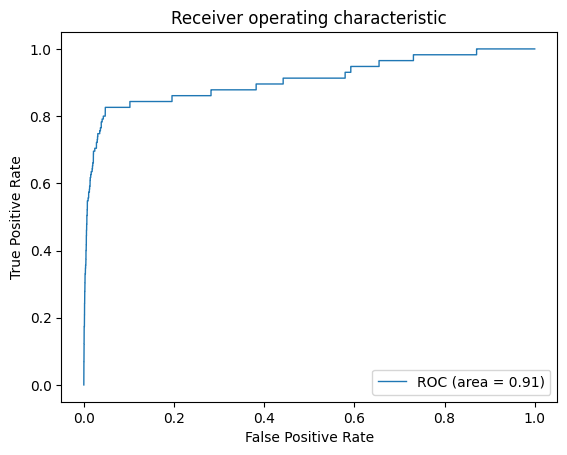

In [73]:
fpr, tpr, thresholds = roc_curve(y_valid, prob_result[2])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
